# Fourier Transforms

The [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) (see also [Fourier Transform](http://mathworld.wolfram.com/FourierTransform.html) on Wolfram) takes a function in _time_ space and transforms it to _frequency_ space. This turns out to be remarkably useful in many situations. The equivalent procedure is used in Quantum Mechanics to change basis between position and momentum space.

You will find that Fourier Transforms are useful in 505,701,702 for Quantum Mechanics, and in 605 for the analysis of analog circuits.

Note that the [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) is related to, but not identical to, the [Fourier Series](https://en.wikipedia.org/wiki/Fourier_series). We will look at the transform first, then look at the series.

Mathematically, we can define the [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) as:
$$
\begin{array}{lcl}
f(t) &=&\frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} F(\omega) e^{i \omega t} d\omega \\
F(\omega) &=& \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} f(t) e^{-i \omega t} dt 
\end{array}
$$
Note that this is a physics-centric definition. Mathematicians would prefer:
$$
\begin{array}{lcl}
f(x) &=& \int_{-\infty}^{\infty} F(k) e^{i 2\pi  k x} dk \\
F(k) &=& \int_{-\infty}^{\infty} f(x) e^{-i 2\pi k x} dx 
\end{array}
$$

You can see that one is obtained from the other with the transformation $\omega = 2\pi k$, taking care that the normalization is adjusted to keep the equations symmetric.

Note that these transformation use complex numbers, and so the functions $f(t)$ and $F(\omega)$ are also considered complex. 

Since the Fourier transform is basically an integral, we already have the tools to do this using the integration we did in [Basic Calculus](https://github.com/mholtrop/Phys601/blob/master/Notebooks/04_Basic_Calculus.ipynb).

You will find that in general on a computer you are doing a [Discrete Fourier Transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform), since you will be taking discrete steps in time (or frequency). For the Discrete Fourier Transform, there are a number of things to be careful about. First, we cannot integrate from $-\infty$ to $\infty$, instead, we integrate from 0 to $T$ (or $-T/2$ to $T/2$), and we have a stepsize of $\Delta T$. The [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist_frequency) tells us that with a stepsize of $\Delta T$, we can only have frequencies up to $\frac{1}{2\Delta T}$, but we will get both positive and negative frequencies. In terms of $\omega$, we thus have $\omega$ betweem $\pm \frac{2\pi}{2\Delta T} = \pm\frac{\pi}{\Delta T}$

We start with some function. To make sure we know the answer beforehand, we will use a function composed of three sines. Also, define some useful variables, $N=$the number of points, $T=$total time simulated, and $DT=$the sample spacing in time. We will have 20 seconds in time here, with a 10001 points total on the t axis. We then create a linear space, i.e. a big array with evenly spaced numbers, each 0.002 apart. 

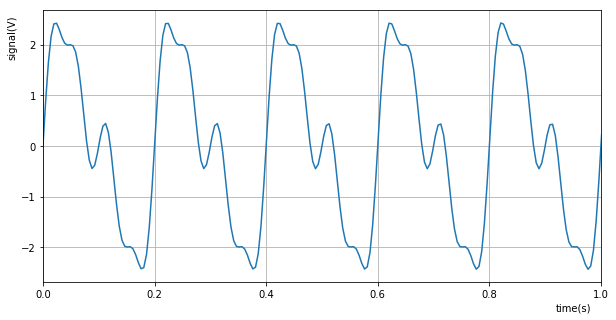

In [8]:
import numpy as np
import matplotlib.pyplot as plt
Freq = 5.
T = 20.     # The length of time determines the resolution of the FFT: how many bins per Hz.
N = 4096    # The total number of points determines the resolution in time: bins per sec. 
            # This translates to the highest available frequency on the FFT
#N=  2**20 # In general FFTs go faster if you do them over 2 to the power N points.
DT = T/N
t = np.linspace(0.,T,N)
y = 2.*np.sin(2*np.pi*Freq*t)+1.*np.sin(2*np.pi*2*Freq*t)++0.5*np.sin(2*np.pi*4*Freq*t)

plt.figure(figsize=(10,5))
plt.plot(t,y)
plt.grid(True)
plt.xlabel("time(s)",position=(0.95,1))
plt.ylabel("signal(V)",position=(1,0.9))
ax = plt.gca()
ax.set_xlim(0.,1.)
plt.show()

We now want to compute the transform using the integral method. Here you should immediately notice that the integral method requires one integral _for each value_ of $\omega$. So for a transform with $N$ points in the input function, and $N$ points in the transform function, you need to do $N$ integrals, so $N^2$ operations. This can be time consuming. 

The points at which we can evaluate $F(\omega)$ are _not_ arbitrary. As mentioned above, they depend on the range and step size of the time ($t$) points of our original funtion. We create an array of $\omega$ points from $-\frac{\pi}{\Delta T}$ to $\frac{\pi}{\Delta T}$ with the same number of points as the time array. We can then step through this omega array and evaluate the integral for each value. 

The code is below:

In [5]:
import scipy.integrate as integrate
omega = np.linspace(-np.pi/DT,np.pi/DT,N) # Create the array of omega values.
F = np.zeros_like(t,dtype='complex')      # Create the output array for the result as complex numbers, same number of steps as t array.
for i in range(len(omega)):               # Step through the omega array by index.
    yy = y*np.exp( -(0+1j)*t*omega[i])    # Compute the result of f(t)*exp( -i*t*omega). Note: complex number i= 0+1i
    F_real = integrate.trapz(np.real(yy),t) # Now integrate the real term of the array and store the result.
    F_imag = integrate.trapz(np.imag(yy),t) # Integrate the imaginary term of the array and store result.
    F[i] = (F_real+1j*F_imag)/np.sqrt(2*np.pi)        # Combine the real + i* imaginary and put in output array.

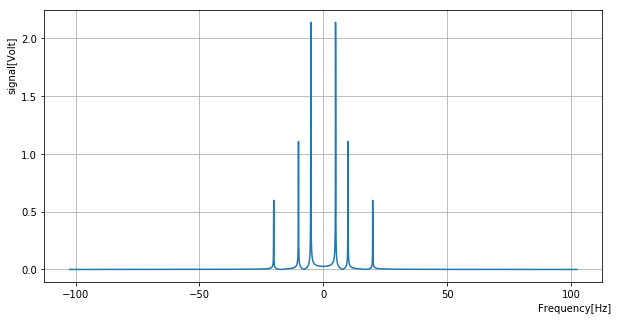

In [15]:
plt.figure(figsize=(10,5))
plt.plot(omega/(2*np.pi),np.abs(F)) # You plot the absolute. The complex angle encodes a phase of the wave.
plt.grid(True)
ax = plt.gca()
#ax.set_xlim(0,30)        # Zoom in: plot only from 0 to 30 Hz.
# plt.yscale("log")      # Uncomment these to get a log-y scale.
# ax.set_ylim(1e-4,1)
plt.xlabel("Frequency[Hz]",position=(0.95,1))
plt.ylabel("signal[Volt]",position=(1,0.8))
plt.show()

You can see that we recover the three frequencies, 5, 10 and 20 Hz, but the peaks have broadened due to the finite step size in time. 

You may also note that this is a slow computation. There is a much faster way to compute the Fourier Transform, called [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform)(FFT). This is a complicated algorithm that takes $N \log(N)$ steps instead of $N^2$ steps. On a computer, especially for large $N$, you always want to do an FFT. There are built in functions to do this. 

We can do the reverse FFT in a similar way.

In [19]:
f = np.zeros_like(t,dtype='complex') 
for i in range(len(t)):               # Step through the omega array by index.
    fy = F*np.exp( (0+1j)*omega*t[i])    # Compute the result of f(t)*exp( -i*t*omega). Note: complex number i= 0+1i
    f_real = integrate.trapz(np.real(fy),omega) # Now integrate the real term of the array and store the result.
    f_imag = integrate.trapz(np.imag(fy),omega) # Integrate the imaginary term of the array and store result.
    f[i] = (f_real+1j*f_imag)                   # Combine the real + i* imaginary and put in output array.

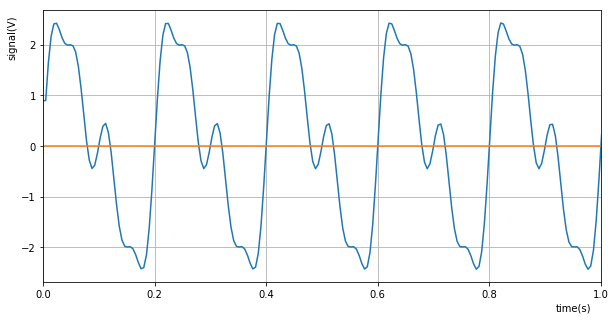

In [20]:
plt.figure(figsize=(10,5))
plt.plot(t,np.real(f))      # In this case, you plot the real term. 
plt.plot(t,np.imag(f))      # The imaginary term should be close to zero.
plt.grid(True)
plt.xlabel("time(s)",position=(0.95,1))
plt.ylabel("signal(V)",position=(1,0.9))
ax = plt.gca()
ax.set_xlim(0.,1.)
plt.show()

# Fast Fourier Transforms, FFT, With Python

Here you will see how you can make Fast Fourier Transforms (FFT) using Python and SciPy. 
This is just a quick example tutorial, the real documentation is at:[scipy.fftpack](https://docs.scipy.org/doc/scipy-0.18.1/reference/tutorial/fftpack.html).

Import the needed libraries:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift

Again, define some useful variables, $N=$the number of points, $T=$total time simulated, and $DT=$the sample spacing in time. We will have 20 seconds in time here, with a 10001 points total on the t axis. We then create a linear space, i.e. a big array with evenly spaced numbers, each 0.002 apart. We show the first 5 elements of the array.

A note on these variable for an FFT. The variable $T$ The total number of points per second, $N/T$, will determine the largest possible frequency that the the simulation can show. The *Nyquist* frequency is defined as $F_N = \frac{N}{2T}$, is the very highest frequency that can be shown, essentially when every other point is a max or a min value. This concepts comes back when we are dealing with Analog to Digital Converters (ADCs). For the FFT, there will be an equal number of points in Frequency space as there will be in Time space, otherwise you would loose or gain information, which is not realistic. Since Frequency space goes from $[-F_N,+F_N]$, you can see that $T$ directly determines how many bins there are per Hz in frequency space. So, if you increase $N$, you will increase how nicely the sinewave is rendered in the Time domain, but you do not increase the resolution (number of bins per Hz) of the Frequency domain. To increase the number of bins in the Frequency domain, we need to increase $T$.

In [5]:
F = 5.
T = 20.     # The length of time determines the resolution of the FFT: how many bins per Hz.
            # The total number of points determines the resolution in time: bins per sec. 
            # This translates to the highest available frequency on the FFT
N=  2**20   # In general FFTs go faster if you do them over 2 to the power N points. 2**20 is A LOT of points!!!
DT = T/N
t = np.linspace(0.,T,N)
t[0:5]

array([0.00000000e+00, 1.90735045e-05, 3.81470090e-05, 5.72205136e-05,
       7.62940181e-05])

Now we want to create some kind of signal. In this case, 3 sine waves with frequencies F, 2F and 4F (5,10,20)Hz, and amplitudes of 2, 1 and 0.5 Volts. We create this signal simply using the sin function from numpy.

In [6]:
y = 2.*np.sin(2*np.pi*F*t)+1.*np.sin(2*np.pi*2*F*t)++0.5*np.sin(2*np.pi*4*F*t)

Let's make a plot of this signal, as it would show up on an osciloscope. We limit the time to 1 second, otherwise it gets very hard to see the actual shape of the wave.

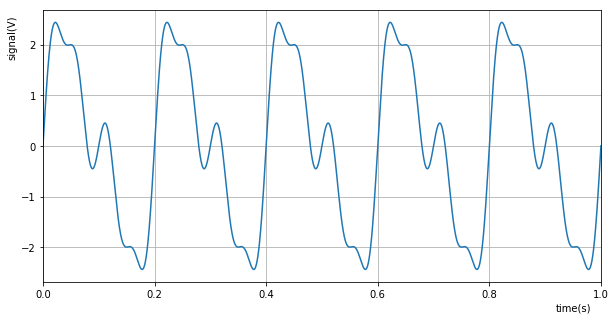

In [7]:
plt.figure(figsize=(10,5))
plt.plot(t,y)
plt.grid(True)
plt.xlabel("time(s)",position=(0.95,1))
plt.ylabel("signal(V)",position=(1,0.9))
ax = plt.gca()
ax.set_xlim(0.,1.)
plt.show()

We now want to see the Fourier Transform of this signal. We need to note a few important details though. First of all, we have a signal that lasts only from 0 to 2 seconds. The full Fourier Transform is defined from $-\infty$ to $+\infty$, so we don't *quite* get three infinitely narrow spikes, which is what we would expect. This issue has to do with the subtle bit of Fast Fourier Transforms called "windowing". Most of the time you can ignore this, if you accept that the window causes artifacts (i.e. the FFT will not perfectly go to zero in between the peaks.)

For the x axis, we use the handy fftfreq() function, which automatically creates the correct x-axis. 

The FFT will have negative and positive frequencies, which in this care are put in the array as [positive values,...,negative values]. This is how the algorithm works, but it doesn't work nice for plotting. The function fftshift() helps out by ordering the array from negative to positive values. In our case, with an input of real values, you only need the positive values of the FFT, so fftshift isn't strictly needed.

We also use ax.set_xlim to set the limit of the x-axis, since otherwise it goes from $-1/2T$ to $+1/2T$. We only need the interval from zero to 30 Hz to see all the signal.

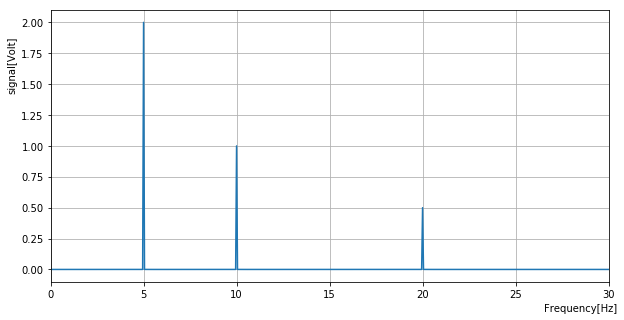

In [8]:
f_fft = fftshift(fftfreq(N,DT))  # Calculate the frequencies, and shift so that f=0Hz is in the center.
y_fft = fftshift(fft(y))         # Calculate the FFT, and also shift so that f=0Hz is in the center.
plt.figure(figsize=(10,5))
plt.plot(f_fft,2./N*np.abs(y_fft)) # Note: the 2./N properly normalizes the FFT amplitude to be in Volts.
plt.grid(True)
ax = plt.gca()
ax.set_xlim(0,30)        # Zoom in: plot only from 0 to 30 Hz.
# plt.yscale("log")      # Uncomment these to get a log-y scale.
# ax.set_ylim(1e-4,1)
plt.xlabel("Frequency[Hz]",position=(0.95,1))
plt.ylabel("signal[Volt]",position=(1,0.8))
plt.show()

Note that this all evaluated much faster than our previous algorithm, eventhough it used _a lot_ more points. Also note that by using more points, you got much narrower peaks in frequency space. They are nearly, but not quite, the delta function (single values) you would get with the full integral.

#### You try it:
Re-execute the code above with different values for N and note the widths of the peaks.

## Square Wave
Now we will look at the FFT of a square wave signal. There is an excellent signal processing library for Python in SciPy called "signal", and it has a ready to go square wave form. See [scipy.signal](https://docs.scipy.org/doc/scipy-0.14.0/reference/signal.html). We will use that to create the waveform and then create the FFT. We will use the same frequency, F. The documentation states we need to multiply with $2\pi$ to get the correct normalization. The amplitude will be from -1 to 1.

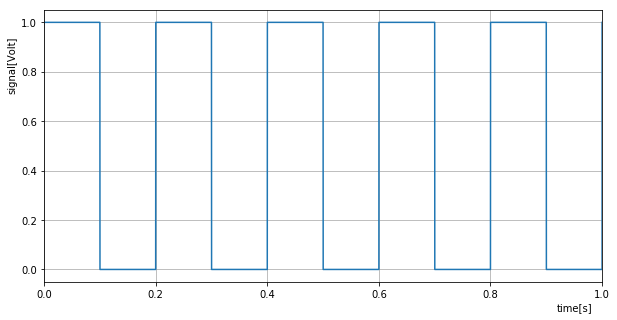

In [9]:
from scipy import signal
y_sq =0.5+0.5*signal.square(2*np.pi*F*t)
plt.figure(figsize=(10,5))
plt.plot(t,y_sq)
plt.grid(True)
plt.xlabel("time[s]",position=(0.95,1))
plt.ylabel("signal[Volt]",position=(1,0.8))
ax = plt.gca()
ax.set_xlim(0,1)
plt.show()

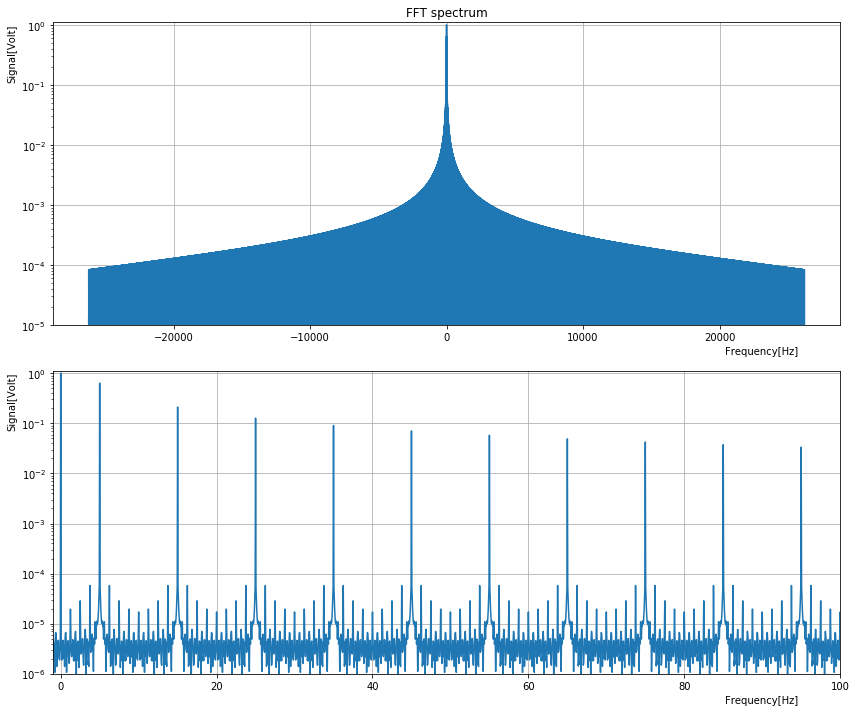

In [10]:
y_sq_fft = fftshift(fft(y_sq)) # Compute the FFT, and shift it so that f=0Hz is at the center (plots better)
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.semilogy(f_fft,2./N*np.abs(y_sq_fft)) # Plot log y and normalize by 2/N so spectrum is in Volt.
plt.grid(True)
ax = plt.gca()
#ax.set_xlim(0,100)
ax.set_ylim(1e-5,1.1)
plt.title("FFT spectrum")
plt.xlabel("Frequency[Hz]",position=(0.9,1))
plt.ylabel("Signal[Volt]",position=(1,0.9))
plt.subplot(2,1,2)                           # Plot again, but zoom in on the first 100 Hz.
plt.semilogy(f_fft,2./N*np.abs(y_sq_fft))
plt.grid(True)
ax = plt.gca()
ax.set_xlim(-1,100)
ax.set_ylim(1e-6,1.1)
plt.xlabel("Frequency[Hz]",position=(0.9,1))
plt.ylabel("Signal[Volt]",position=(1,0.9))
plt.tight_layout()          # Automatically adjust spacing between the 2 plots so they do not overlap
plt.show()

What we see is that the sharp edges of the square wave can only be made with really high frequencies. Also, note all the "noise" at low values $\approx 10^{-3}$, which should all be zero. They are not because of rounding errors in the computation and the

The shape of the FFT is exactly what you expect from Fourier Transforms theory of a square wave: an infinite series of spikes a distance of $2F$ apart, with diminishing amplitudes. The series is truncated in our case because of the limited time for the input signal. The log y-scale emphasizes the artifacts due to the windowing. They would diminish as we let $N\rightarrow\infty$.

We can take the FFT spectrum of our signal and do a reverse FFT to recover the original shape. Depending on the quality of the original FFT, the inverse may show artifacts. Try this by executing this notebook and changing the time span and/or number of points in the FFT and see how the FFT spectrum, and the inverse, change.

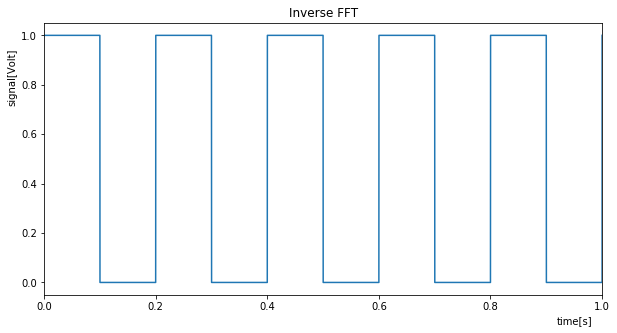

In [11]:
rev_fft = ifft(ifftshift(y_sq_fft))     # Un-shift the fft spectrum first.
plt.figure(figsize=(10,5))
plt.plot(t,np.abs(rev_fft))
plt.title("Inverse FFT")
plt.xlabel("time[s]",position=(0.95,1))
plt.ylabel("signal[Volt]",position=(1,0.8))
ax = plt.gca()
ax.set_xlim(0,1.)
plt.show()

#### You try it:
Try to compute the fourier transform for other input sequences: triangle waves and a wave packet.

# Fourier Series
The [Fourier Series](https://en.wikipedia.org/wiki/Fourier_series) is a special case of the Fourier Transform to represent a periodic (i.e. repeating) signal, on the domain $[-\pi,pi]$, as a sum of sines and cosines. The mathematical statement is:
$$\begin{array}{lcl}
f(x) &=& \frac{1}{2} a_0 + \sum_{n=1}^{\infty} a_n \cos(n x) + \sum_{n=1}^{\infty} b_n \sin(n x)  \\
a_0 &=& \frac{1}{\pi} \int_{-\pi}^\pi f(x) dx \\
a_n &=& \frac{1}{\pi} \int_{-\pi}^\pi f(x) \cos(n x) dx \\
b_n &=& \frac{1}{\pi} \int_{-\pi}^\pi f(x) \sin(n x) dx 
\end{array}
$$ 
Any well behaved function $f(x)$ can be expanded this way. (In Quantum Mechanics you will learn that sine and cos are not the only expansion possibilities. This works for any _complete set of orthogonal functions_). Using Euler's formula: $e^{i\phi} = \cos(\phi) + i\sin(\phi)$, you can see that the Fourier Series is closely related to the Fourier Transform, with the $a_n$ being the _real_ components and the $b_n$ the _imaginary_ components, and $ nx = n\Delta t = t$. The difference between the two is thus only a scaling of the axes. 

Since you usually only calculate a few terms (i.e. 10) of the Fourier Series, the advantage of doing an FFT is now not so great, and mathematically a direct computation of the terms is often more clear.

#### Try it:
Compute the first 5 terms for a saw-tooth shape wave with direct computation, and plot the terms. See: https://www.desmos.com/calculator/lab9nylxsi for the expected output.